# 15.11.2024

In [1]:
import math
import numpy as np
import scipy.stats as sps 
import scipy.optimize
from tqdm import trange
import matplotlib.pyplot as plt

In [2]:
N = 10 ** 3
STD = 0.05
A = (0.0, 1.0, 1.0)
uniform_boundary = (3 * STD) / math.sqrt(3)
laplace_lambda = STD / math.sqrt(2)
EPS_DISTR = {"Norm":    sps.norm(loc=0, scale=STD),
             "Uniform": sps.uniform(loc=-uniform_boundary, scale=2 * uniform_boundary),
             "Laplace": sps.laplace(loc=0, scale = laplace_lambda)}

Проверим, что это действительно случайные величины с СКО равным $0.05$

In [3]:
for d in EPS_DISTR:
    print(f"{d}: E[r] = {EPS_DISTR[d].stats('m')}, Var[r] = {EPS_DISTR[d].stats('v'):.5f}, STD = {math.sqrt(EPS_DISTR[d].stats('v')):.3f}")

Norm: E[r] = 0.0, Var[r] = 0.00250, STD = 0.050
Uniform: E[r] = 0.0, Var[r] = 0.00250, STD = 0.050
Laplace: E[r] = 0.0, Var[r] = 0.00250, STD = 0.050


Наша функция $f$, параметры которой мы хотим оценить $$f(x, \vec{a}) = \frac{x a_1 + a_0}{x + a_2}$$

In [4]:
def f(x, a):
    return (x * a[1] + a[0]) / (x + a[2])

Зададим метрики функционала невязки, которые мы хотим минимизировать для каждой регрессии

In [5]:
def ols(a, xs, ys):
    return sum([(y - f(x, a)) ** 2 for x, y in zip(xs, ys)])

def lar(a, xs, ys):
    return sum([abs(y - f(x, a)) for x, y in zip(xs, ys)])

def minimax(a, xs, ys):
    return max([abs(y - f(x, a)) for x, y in zip(xs, ys)])

Будем минимизировать их с помощью `scipy.optimize.minimize`

In [6]:
def fit_regression(regression, xs, ys):
    return scipy.optimize.minimize(regression, A, args=(xs, ys)).x

In [7]:
REGRESSIONS = {"OLS": ols,
               "LAR": lar,
               "minimax": minimax}

In [8]:
XS = np.linspace(0.1, 3.0, num=30)

In [9]:
coeffs = {"OLS": {eps : [] for eps in EPS_DISTR},
          "LAR": {eps : [] for eps in EPS_DISTR},
          "minimax": {eps : [] for eps in EPS_DISTR}}
for eps in EPS_DISTR:
    for _ in trange(N):
        YS = np.array([f(x, A) + EPS_DISTR[eps].rvs() for x in XS])
        for model in REGRESSIONS:
            regression_coeffs = fit_regression(REGRESSIONS[model], XS, YS)
            coeffs[model][eps].append(regression_coeffs)

100%|██████████| 1000/1000 [00:44<00:00, 22.35it/s]


In [10]:
estimate_variance = {"OLS": {eps : [] for eps in EPS_DISTR}, 
                      "LAR": {eps : [] for eps in EPS_DISTR},
                      "minimax": {eps : [] for eps in EPS_DISTR}}
for eps in EPS_DISTR:
    for model in REGRESSIONS:
        estimate_variance[model][eps] = np.std(coeffs[model][eps], axis=0) ** 2

In [11]:
estimate_variance

{'OLS': {'Norm': array([0.00390442, 0.00600947, 0.09209984]),
  'Uniform': array([0.00435259, 0.00657085, 0.10210932]),
  'Laplace': array([0.00394139, 0.00620766, 0.09349489])},
 'LAR': {'Norm': array([0.00458601, 0.00699131, 0.10180249]),
  'Uniform': array([0.00948642, 0.01400238, 0.222467  ]),
  'Laplace': array([0.00312494, 0.00362852, 0.05857288])},
 'minimax': {'Norm': array([0.00097752, 0.00095951, 0.00060032]),
  'Uniform': array([0.00011921, 0.00017025, 0.00086321]),
  'Laplace': array([0.00222627, 0.00262565, 0.00232822])}}

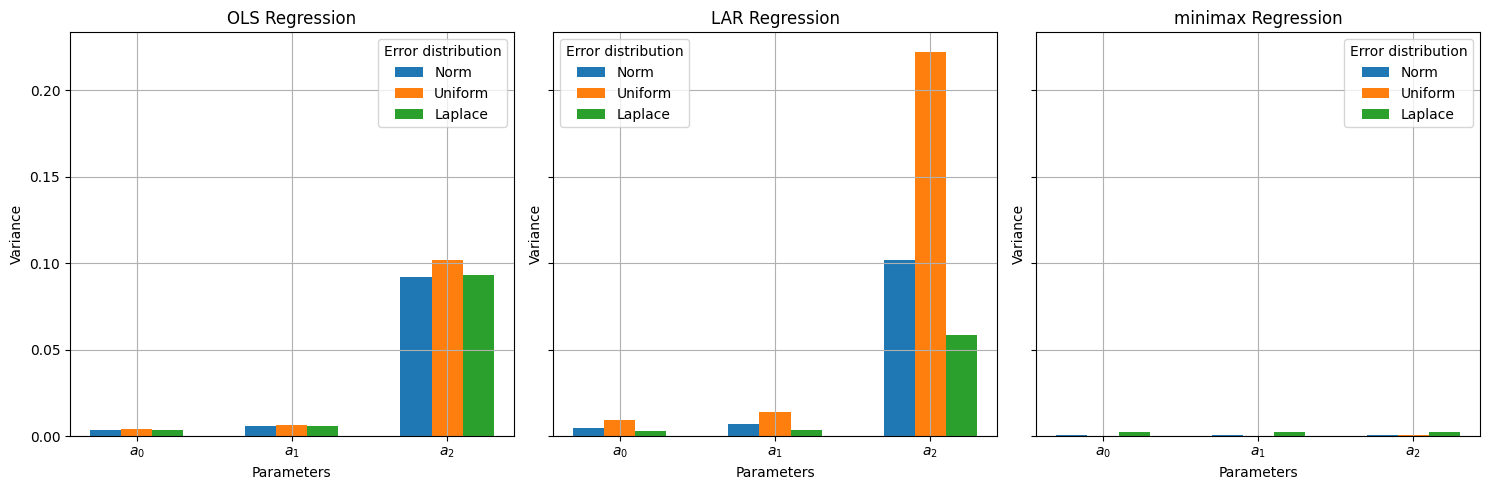

In [12]:
bar_width = 0.2
index = np.arange(len(estimate_variance['OLS']))

_, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for i, (regression, distributions) in enumerate(estimate_variance.items()):
    ax: plt.Axes = axes[i]
    for j, (distribution, stdevs) in enumerate(distributions.items()):
        ax.bar(index + bar_width * j, stdevs, bar_width, label=distribution, color='C'+str(j))

    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(['$a_0$', '$a_1$', '$a_2$'])
    ax.set_xlabel('Parameters')
    ax.set_title(f'{regression} Regression')
    ax.set_ylabel('Variance')

    ax.legend(title="Error distribution")
    ax.grid(which='major')

plt.tight_layout()
plt.show()